# Transfer learning

We will continue working on the chest x-ray dataset, from [Kermany et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418301545?via%3Dihub)
 but this time we will stand closer to the original paper because we will use transfer learning.

![fig 1 of "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning" by Kermany et al.](https://github.com/sib-swiss/pytorch-practical-training/blob/master/images/tranfer_learning_xray.jpg?raw=1)

The base model we will re-use is [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).



With inspirations from [this github repo](https://github.com/liyu95/Deep_learning_examples/blob/master/4.ResNet_X-ray_classification/Densenet_fine_tune.ipynb) and [this kaggle thread](https://www.kaggle.com/code/iamsdt/transferlearning-pytorch-resnet-50)

In [1]:
## on google colab, you will have to run the following line:
!pip install pytorch-model-summary
!wget https://github.com/Bjarten/early-stopping-pytorch/raw/refs/heads/main/early_stopping_pytorch/early_stopping.py
!mv early_stopping.py pytorchtools.py

--2025-12-02 12:14:26--  https://github.com/Bjarten/early-stopping-pytorch/raw/refs/heads/main/early_stopping_pytorch/early_stopping.py
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Bjarten/early-stopping-pytorch/refs/heads/main/early_stopping_pytorch/early_stopping.py [following]
--2025-12-02 12:14:26--  https://raw.githubusercontent.com/Bjarten/early-stopping-pytorch/refs/heads/main/early_stopping_pytorch/early_stopping.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2416 (2.4K) [text/plain]
Saving to: ‘early_stopping.py’

early_stopping.py   100%[===================>]   2.36K  --.-KB/s  

In [2]:
## on google colab, you will have to run the following lines:

## downloading example images:
!mkdir images
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/images/cat.jpg -O images/cat.jpg
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/images/car.jpg -O images/car.jpg
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/images/pandas_cat.jpg -O images/pandas_cat.jpg
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/images/NORMAL-1003233-0001.jpeg -O images/NORMAL-1003233-0001.jpeg
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/images/BACTERIA-1008087-0001.jpeg -O images/BACTERIA-1008087-0001.jpeg


## downloading an unzipping the full datasets (resized)
!wget https://sibcloud-my.sharepoint.com/:u:/g/personal/wandrille_duchemin_sib_swiss/ESDXFrlw6JJGiK8X7xG4aVEB06cxW82KyK_KWXMwccIVhw?download=1 -O chest_xray_224.zip

!mkdir data
!unzip chest_xray_224.zip
!mv chest_xray_224 data

## downloading embedded data
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/data/chest_Xray_train_embed.pt -O data/chest_Xray_train_embed.pt
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/data/chest_Xray_valid_embed.pt -O data/chest_Xray_valid_embed.pt
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/data/chest_Xray_train_y.pt -O data/chest_Xray_train_y.pt
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/data/chest_Xray_valid_y.pt -O data/chest_Xray_valid_y.pt



Streaming output truncated to the last 5000 lines.
 extracting: chest_xray_224/train/NORMAL/NORMAL_339.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_1215.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_217.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_810.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_1100.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_928.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_1265.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_706.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_718.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_1207.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_1002.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_740.jpeg  
  inflating: chest_xray_224/train/NORMAL/NORMAL_1292.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_1147.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_586.jpeg  
 extracting: chest_xray_224/train/NORMAL/NORMAL_1197.jpeg

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pytorch_model_summary as pms

from torch.utils.data import TensorDataset, DataLoader

from torchvision.transforms import v2
import torchvision

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
from torchvision.models import resnet50, ResNet50_Weights

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
RN50_model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
RN50_model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The inference transforms are available at `ResNet50_Weights.IMAGENET1K_V2.transforms`
and perform the following preprocessing operations:
 * Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.
 * The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR,
 * followed by a central crop of crop_size=[224].
 * Finally the values are first rescaled to [0.0, 1.0]
 * then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [5]:
def make_np_img( img ):
    np_img = torch.moveaxis(img,0,2).numpy()
    m = np_img.min()
    M = np_img.max()
    r = M-m
    return (np_img - m)/r


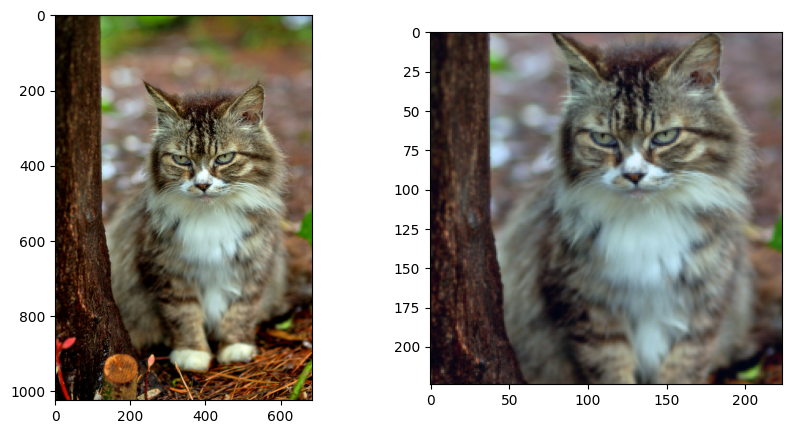

In [6]:
from torchvision.io import read_image
RN50_transformer = ResNet50_Weights.IMAGENET1K_V2.transforms( antialias=True)

cat = read_image( "images/cat.jpg" )
cat_t = RN50_transformer(cat)

fig,ax = plt.subplots(1,2 , figsize = (10,5))
## Tensor are in C,H,W shape, but imshow wants H,W,C
## so we move axis 0 to index 2
ax[0].imshow( torch.moveaxis(cat,0,2).numpy())
ax[1].imshow( make_np_img( cat_t ))

In [9]:
RN50_dategories = np.array( ResNet50_Weights.DEFAULT.meta['categories'] )
RN50_dategories[:5]

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead'], dtype='<U30')

In [10]:
cat_t = cat_t.to(device)
with torch.no_grad():
    pred = RN50_model(cat_t.unsqueeze(0))
    class_probas = pred.squeeze(0).softmax(0).cpu()
    print( "class proba shape",class_probas.shape )
    print( 'probas:    ', class_probas[:5] , '...' )
    print( 'categories:',RN50_dategories[:5] , '...')



class proba shape torch.Size([1000])
probas:     tensor([0.0010, 0.0007, 0.0011, 0.0011, 0.0011]) ...
categories: ['tench' 'goldfish' 'great white shark' 'tiger shark' 'hammerhead'] ...


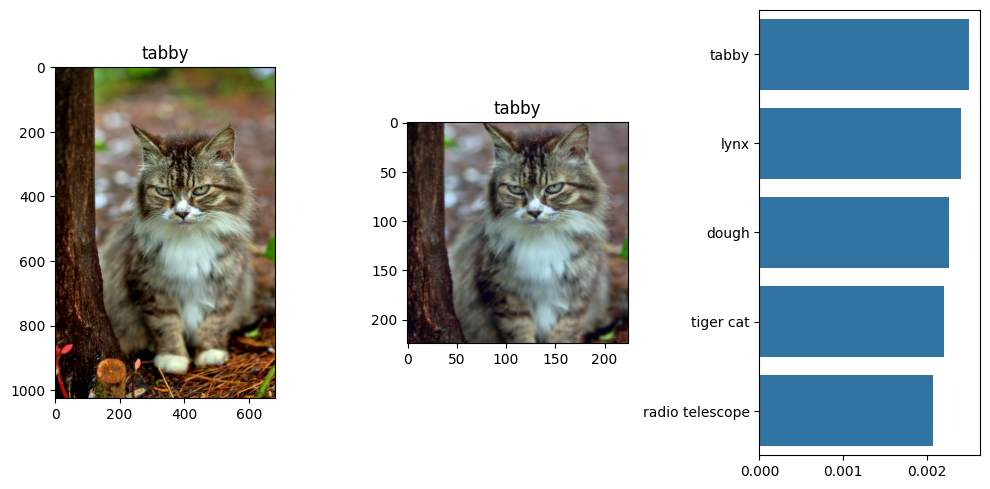

In [11]:
def RN50_predict( img ):
    img_t = RN50_transformer( img )

    img_t = img_t.to(device)
    with torch.no_grad():
        pred = RN50_model(img_t.unsqueeze(0))
        class_probas = pred.squeeze(0).softmax(0)

    order = np.argsort( class_probas.cpu().numpy()  )[::-1]

    fig,ax = plt.subplots(1,3 , figsize = (10,5))
    ax[0].imshow(torch.moveaxis(img,0,2).cpu().numpy())
    ax[0].set_title(RN50_dategories[order[0]])
    ax[1].imshow( make_np_img( img_t.cpu() ) )
    ax[1].set_title(RN50_dategories[order[0]])

    sns.barplot( x = class_probas.cpu().numpy()[order[:5]],
             y = RN50_dategories[order[:5]] , ax = ax[2])
    plt.tight_layout()
RN50_predict( cat )

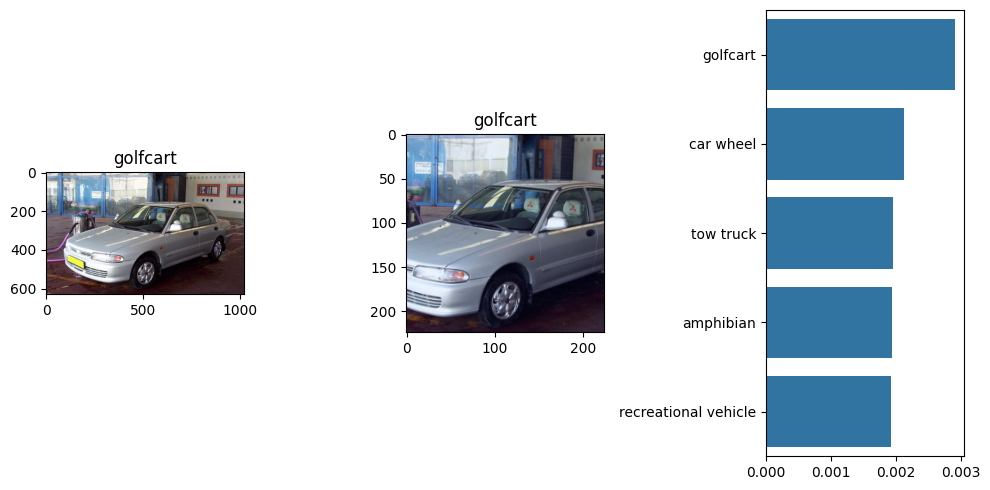

In [12]:
RN50_predict( read_image("images/car.jpg") )

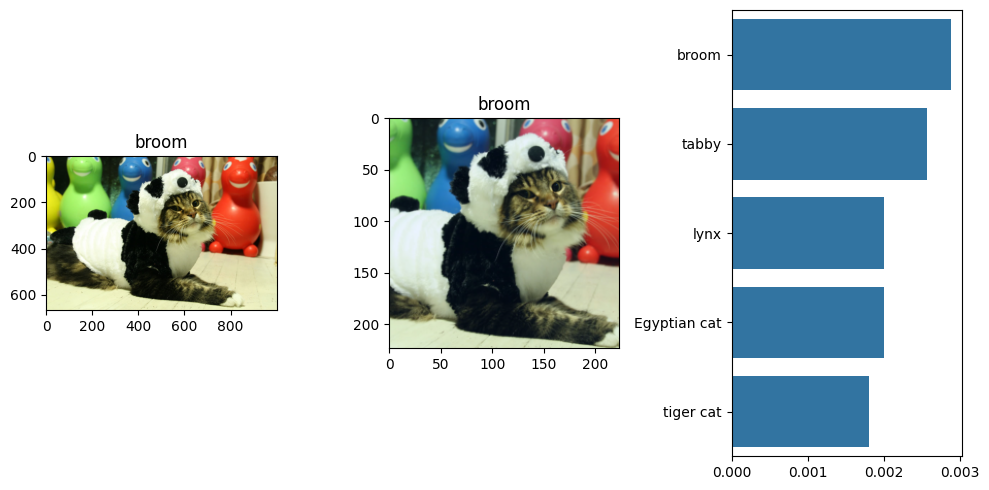

In [13]:
RN50_predict( read_image("images/pandas_cat.jpg") )

Now, if we try it on our x-ray images:

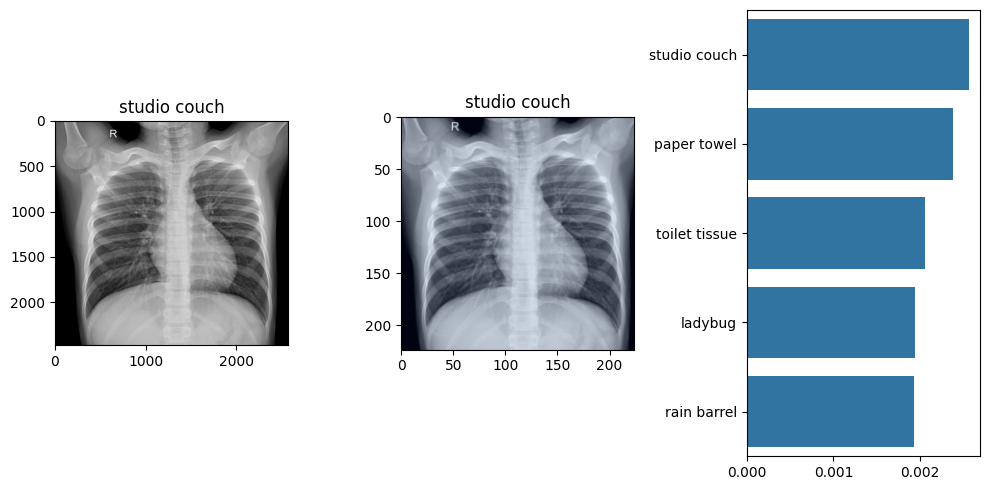

In [17]:
## force the image to be RGB
img = read_image("images/NORMAL-1003233-0001.jpeg" ,
                 mode=torchvision.io.ImageReadMode.RGB )

RN50_predict(img)

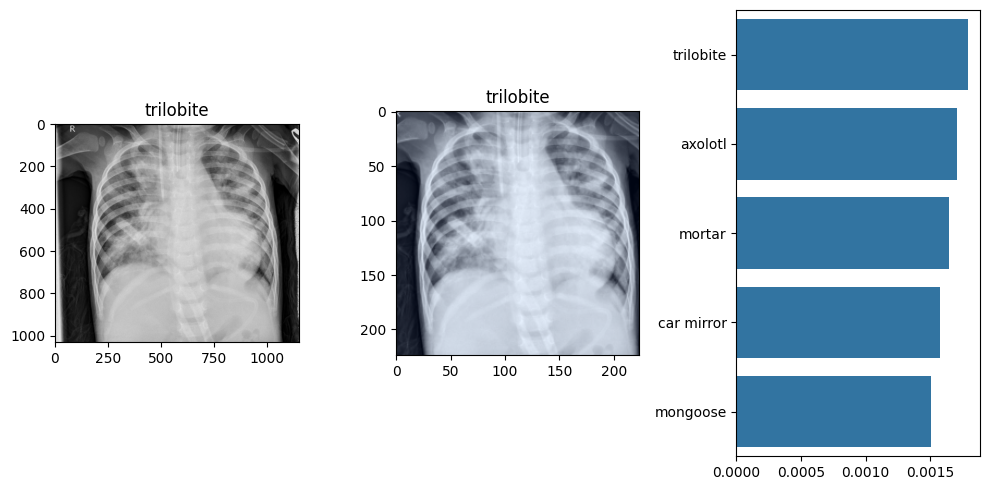

In [18]:
img = read_image("images/BACTERIA-1008087-0001.jpeg" ,
                 mode=torchvision.io.ImageReadMode.RGB )

RN50_predict(img)

As expected, it does not make sense.

---

## setting up transfer-learning

Rather than train a model from scratch as we did previously, we will leverage this complex model with [transfer learning](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks#parameter-tuning).

So we will freeze most layers of resnet50 and plug our own classifier on top.

![small Transfer Learning representation from https://stanford.edu/~shervine/teaching/cs-230/](https://stanford.edu/~shervine/teaching/cs-230/illustrations/transfer-learning-small-ltr.png?bee5e73de8fb2c6297a3a88804fabf5e)

In [33]:
cat_t = RN50_transformer(cat).to(device)
print(pms.summary(RN50_model, cat_t.unsqueeze(0) , show_input=True))

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 224, 224]           9,408               0
          BatchNorm2d-2     [1, 64, 112, 112]             128               0
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4     [1, 64, 112, 112]               0               0
           Bottleneck-5       [1, 64, 56, 56]          75,008               0
           Bottleneck-6      [1, 256, 56, 56]          70,400               0
           Bottleneck-7      [1, 256, 56, 56]          70,400               0
           Bottleneck-8      [1, 256, 56, 56]         379,392               0
           Bottleneck-9      [1, 512, 28, 28]         280,064               0
          Bottleneck-10      [1, 512, 28, 28]         280,064               0
          Bottleneck-11      [1, 512, 28, 28]         280,064  

In [34]:
RN50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# we freeze all layers by setting their parameters .requires_grad=False
for param in RN50_model.parameters():
    param.requires_grad = False

In [37]:
## the layer we want to replace is called fc

# Parameters of newly constructed modules have requires_grad=True by default
input_dim = RN50_model.fc.in_features

RN50_model.fc = nn.Sequential(nn.Linear(input_dim , 1),
                              nn.Sigmoid() ).to(device)


AttributeError: 'Sequential' object has no attribute 'in_features'

In [38]:
cat_t = RN50_transformer(cat).to(device)
print(pms.summary(RN50_model, cat_t.unsqueeze(0) , show_input=True))

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 224, 224]           9,408               0
          BatchNorm2d-2     [1, 64, 112, 112]             128               0
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4     [1, 64, 112, 112]               0               0
           Bottleneck-5       [1, 64, 56, 56]          75,008               0
           Bottleneck-6      [1, 256, 56, 56]          70,400               0
           Bottleneck-7      [1, 256, 56, 56]          70,400               0
           Bottleneck-8      [1, 256, 56, 56]         379,392               0
           Bottleneck-9      [1, 512, 28, 28]         280,064               0
          Bottleneck-10      [1, 512, 28, 28]         280,064               0
          Bottleneck-11      [1, 512, 28, 28]         280,064  

## setup the dataloaders

In [39]:
read_image_rgb = lambda x : read_image(x , mode=torchvision.io.ImageReadMode.RGB)

train_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/train',
                                         loader = read_image_rgb,
                                         transform = RN50_transformer,
                                         target_transform = lambda x : torch.Tensor([x])  )
valid_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/test',
                                         loader = read_image_rgb,
                                         transform = RN50_transformer,
                                         target_transform = lambda x : torch.Tensor([x])   )


batch_size = 64
train_dataloader = DataLoader( dataset= train_dataset , shuffle=True , batch_size = batch_size )
valid_dataloader = DataLoader( dataset= valid_dataset , shuffle=True , batch_size = batch_size )


In [25]:
X,y = next(iter(train_dataloader))
X.shape , y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1]))

In [26]:
%%time
loss = nn.BCELoss()

with torch.no_grad():
    pred = RN50_model(X.to(device))
    print(pred.shape)
    print( 'avg loss:', loss( pred , y.to(device) ) )

torch.Size([64, 1])
avg loss: tensor(0.7270)
CPU times: user 14.6 s, sys: 6.32 s, total: 20.9 s
Wall time: 21.1 s


From there we would train the model as we usually do.

However, in that particular case you can notice that just predicting 1 batch of 64 images took almost 4s on my measly CPU.

So to go through the 5,858 images of the dataset:

In [27]:
((4/64)*5858)/60

6.102083333333334

I would need about 6 minutes.

So I would have fairly long epochs, and that is without even counting the backward pass.

Now, I could upgrade to a computer with a good GPU, but I could also apply reason like follow:

 * We have fixed all layers of Resnet50, expect the last
 * So at each epoch we compute the same thing, except for the last component
 * Going through all these layers is time consuming
 * Why not go though all these fixed layers once, and then train a model on this

Basically, we would use a truncated Resnet50 model as a way to embed our 224x224 image (~50,176 pixels) into a 2048 feature space.

And then we would train a classifier from that space

**exercise** : modify the last layer so it does not modify the output and compute the embedding for 1 batch.

In [44]:
RN50_model.fc = nn.Identity().to(device)

with torch.no_grad():

    X,y = next(iter(train_dataloader))
    pred = RN50_model(X.to(device))
    print(pred.shape)
    print( 'avg loss:', loss( pred , y.to(device) ) )

torch.Size([64, 2048])


ValueError: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 2048])) is deprecated. Please ensure they have the same size.

In [ ]:
 %load solutions/TL_resnet50_embed.py

In [ ]:
with torch.no_grad():
    X,y = next(iter(train_dataloader))

    embedding = RN50_model(X.to(device))

print( embedding.shape )

In [ ]:
embedding

---
> What follow is the precomputation of the embeddings, which takes about 7min.

In [ ]:
# %load solutions/embed_all.py

Then we read the embedding from files where we have saved them:

In [156]:
train_embedding = torch.load('data/chest_Xray_train_embed.pt')
train_Ys = torch.load('data/chest_Xray_train_y.pt')
valid_embedding = torch.load('data/chest_Xray_valid_embed.pt')
valid_Ys = torch.load('data/chest_Xray_valid_y.pt')

## Exercise: fit the embedded data

setup your dataloaders, create your model, and train it

 * a couple of linear + ReLu layers do the trick to learn from the embedding
 * for the optimizer SGD with a learning rate of $10^{-2}$ worked in my tests

In [157]:
train_embedding.shape, train_Ys.shape


(torch.Size([5232, 2048]), torch.Size([5232, 1]))

setup dataloader

In [142]:
# %load -r 1-17 solutions/TL_model_embed.py
batch_size = 32
# transform to torch tensor
X_train_tensor = torch.Tensor(train_embedding)
y_train_tensor = torch.Tensor(train_Ys)

# create your dataset
train_dataset = TensorDataset(train_embedding, train_Ys)

## creating a dataloader
train_dataloader = DataLoader(train_dataset , batch_size = batch_size)

# transform to torch tensor
X_valid_tensor = torch.Tensor(valid_embedding)
y_valid_tensor = torch.Tensor(valid_Ys)

# create your dataset
valid_dataset = TensorDataset(valid_embedding, valid_Ys)

## creating a dataloader
valid_dataloader = DataLoader(valid_dataset)


train_dataset = TensorDataset( train_embedding,
                               train_Ys)


batch_size = 64

## creating a dataloader
train_dataloader = DataLoader( train_dataset , shuffle = True , batch_size = batch_size )

# create your dataset
valid_dataset = TensorDataset( valid_embedding,
                               valid_Ys)


In [143]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([5232, 2048]), torch.Size([5232, 1]))

define model

In [149]:
# %load -r 18-44 solutions/TL_model_embed.py
class embedding_nn(torch.nn.Module):

    def __init__(self , input_dim = 2048, # input layer
                         hidden_dim=[80], # hidden layers
                         dropout_fraction = 0.25):
        super().__init__()

        ## we transform the input from 2D to 1D
        self.flatten = nn.Flatten()

        elements = []

        # each layer is made of a linear layer with a ReLu activation and a DropOut Layer
        for i in range(len(hidden_dim)):

            elements.append( nn.Linear(input_dim, hidden_dim[i]) )
            elements.append( nn.ReLU() )
            elements.append( nn.Dropout(dropout_fraction) )

            input_dim = hidden_dim[i] ## update the input dimension for the next layer

        elements.append( nn.Linear(input_dim, 1) )
        elements.append( nn.Sigmoid() )

        self.layers = nn.Sequential( *elements )

    def forward(self, x):
        #x = self.flatten(x)
        ## NB: here, the output of the last layer are logits
        logits = self.layers(x)
        return logits


model = embedding_nn(input_dim = 2048, hidden_dim=[60], dropout_fraction=0.25).to(device)
print(model)

embedding_nn(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=2048, out_features=60, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=60, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


define helper functions

In [150]:
# %load -r 45-111 solutions/TL_model_embed.py
torch.zeros(1, 2048).to(device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [151]:
print(pms.summary(model, torch.zeros(1, 2048).to(device), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [1, 2048]         122,940         122,940
            ReLU-2             [1, 60]               0               0
         Dropout-3             [1, 60]               0               0
          Linear-4             [1, 60]              61              61
         Sigmoid-5              [1, 1]               0               0
Total params: 123,001
Trainable params: 123,001
Non-trainable params: 0
-----------------------------------------------------------------------


training setup

In [152]:
# %load -r 112-127 solutions/TL_model_embed.py

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
#class_weights = compute_class_weight(class_weight='balanced' ,
#                                     classes = np.array(list( range(10) )),
#                                     y= train_Ys
#                                    )

def get_additional_scores(predicted , target):
    #sample_weights = class_weights[target]

    return { 'balanced_accuracy' : metrics.balanced_accuracy_score( target , predicted),
             'accuracy' : metrics.accuracy_score( target , predicted ),
             'f1' : metrics.f1_score( target , predicted ,
                                     average = 'macro' ) }

get_additional_scores(np.argmax(pred.detach().cpu().numpy(),axis=1), y.cpu().numpy())


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


{'balanced_accuracy': np.float64(0.0), 'accuracy': 0.0, 'f1': 0.0}

In [153]:
def train_func(dataloader, model, loss_fn, optimizer , echo = True):

    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.

    for batch, (X, y) in enumerate(dataloader): # for each batch
        X, y = X.to(device), y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred.squeeze(), y)      # loss function from these prediction

        # Backpropagation
        loss.backward()              # backward propagation
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

        optimizer.step()
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo:
            current =  (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    # return the last batch loss:
    return loss.item()

def valid_func(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss, correct = 0, 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y.unsqueeze(1)).item()  ## accumulating the loss function over the batches

            correct += ((pred>0.5).float() == y.unsqueeze(1)).float().sum().item() ## counting number of true predictions

    valid_loss /= num_batches
    correct /= size
    if echo:
        print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    ## return the average loss / batch
    return valid_loss


initial round

In [154]:
# %load -r 128-140 solutions/TL_model_embed.py
## preamble -> define the model, the loss function, and the optimizer
model = embedding_nn(input_dim = 2048,
                     hidden_dim=[60]).to(device)

loss_fn = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(),
#                       lr = 10**-4,
#                       weight_decay = 10**-2)
optimizer = torch.optim.SGD(model.parameters(), lr = 5*10**-5 , momentum=0.9)


In [155]:
## container to keep the scores across all epochs
#train_scores = defaultdict(list)
#valid_scores = defaultdict(list)
epochs = 50
train_losses = []
valid_losses = []

for t in range(epochs):
    train_losses.append( train_func(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid_func(valid_dataloader, model, loss_fn , echo = False) )
print("Done!")
plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')
valid(valid_dataloader, model, loss_fn , echo = True)

ValueError: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])) is deprecated. Please ensure they have the same size.

In [69]:
%%time
## lets do a single round, to learn how long it takes
tmp_scores = train(train_dataloader,
                   model,
                   loss_fn,
                   optimizer,
                   get_additional_scores ,
                   echo = True , echo_batch = True )
train_scores.append( tmp_scores)

tmp_scores = valid(valid_dataloader,
                   model,
                   CEloss ,
                   get_additional_scores ,
                   echo = True)
valid_scores.append(tmp_scores)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

training

In [ ]:
# %load -r 141-171 solutions/TL_model_embed.py
%%time
epochs = 100


for t in range(1,epochs+1):

    echo = t%10==0
    if echo:
        print('Epoch',t )

    tmp_scores = train(train_dataloader,
                       model,
                       CEloss,
                       optimizer,
                       get_additional_scores ,
                       echo= echo , echo_batch=False )
    for k in tmp_scores:
        train_scores[k].append( tmp_scores[k] )



    tmp_scores = valid(valid_dataloader,
                       model,
                       CEloss ,
                       get_additional_scores ,
                       echo = echo)
    for k in tmp_scores:
        valid_scores[k].append( tmp_scores[k] )
print("Done!")

results

In [ ]:
# %load -r 172- solutions/TL_model_embed.py
fig, axes = plt.subplots(2,2,figsize = (14,8))


for i,k in enumerate( ['loss', 'balanced_accuracy', 'accuracy', 'f1'] ) :

    axes[i//2][i%2].plot(train_scores[k] , label = 'train')
    axes[i//2][i%2].plot(valid_scores[k], label = 'validation')
    axes[i//2][i%2].legend()
    axes[i//2][i%2].set_xlabel('epoch')
    axes[i//2][i%2].set_ylabel(k)




## merging the two models

In [ ]:
import copy
RN50_model.fc = copy.deepcopy( model.layers )

## saving and loading the model

In [ ]:
## saving
torch.save(RN50_model, "modified_RN50.model")

## loading
RN50_model_loaded = torch.load( "modified_RN50.model" , weights_only=False)
RN50_model_loaded

## extra task: don't limit yourself to Neural Networks

once you have the embedding you can apply whatever ML methodology you want.


In [ ]:
X_train = train_embedding.cpu().numpy()
y_train = train_Ys.cpu().squeeze().numpy()

In [ ]:
X_valid = valid_embedding.cpu().numpy()
y_valid = valid_Ys.cpu().squeeze().numpy()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform( X_train )
pca.explained_variance_ratio_

In [ ]:
sns.scatterplot( x = x_pca[:,0] , y = x_pca[:,1] , hue = y_train )

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

logi_r=LogisticRegression(solver = 'liblinear',n_jobs=1)

pipeline_lr=Pipeline([('model',logi_r)])



grid_values = {'model__C': np.logspace(-1,0,10),
               'model__penalty': ['l1'] }

grid_lr = GridSearchCV(pipeline_lr,
                           param_grid = grid_values,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=1)
grid_lr.fit( X_train , y_train )
print('Grid best parameter (max. accuracy): ', grid_lr.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr.best_score_)#get the best score calculated from the train/validation dataset
print('validation set score:' ,accuracy_score(y_valid , grid_lr.predict(X_valid)) )